# Mean values along PL tracks

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
from path import Path
import string
#
import arke
#
import mypaths
import misc_utils as misc
from plot_utils import cc

In [3]:
plt.style.use('./paperfig.mplstyle')

In [4]:
um_res = arke.units.GrdStep('km2p2')

In [5]:
pl_cases = dict(
    STARS72='20070404T1200Z',
    STARS77='20080129T1200Z'
)
runs = ['ctrl', 'nosva', 'sva200', 'ice76n', 'ice82n']

fcst_strs = [*pl_cases.values()]

In [6]:
vrbls = 'vort_mslp'

tracks = {}
for fcst in pl_cases.values():
    tracks[fcst] = {}
    for run in runs:
        input_dir = mypaths.trackdir / fcst / run
        tracks[fcst][run] = pd.read_csv(input_dir / f'pl_loc.{fcst}.{um_res}.{run}.{vrbls}.txt', parse_dates=[0])

In [7]:
vrbls = [
('rel_vort', dict(meanmax=0, ylim=[0, 20], scl=1e5, ylabel='Relative vorticity', unit='s^{-1}')),
('shf', dict(meanmax=0, ylim=[0, 350], scl=1, ylabel='Sensible heat flux', unit='W m^{-2}')),
]

In [8]:
with h5py.File(mypaths.trackdir.parent.glob('*.h5')[0], 'r') as hf:
    data = {}
    for fcst in pl_cases.values():
        data[fcst] = {}
        for run in runs:
            data[fcst][run] = {}
            for vrbl in vrbls:
                data[fcst][run][vrbl[0]] = hf.get(fcst).get(run).get(vrbl[0]).value

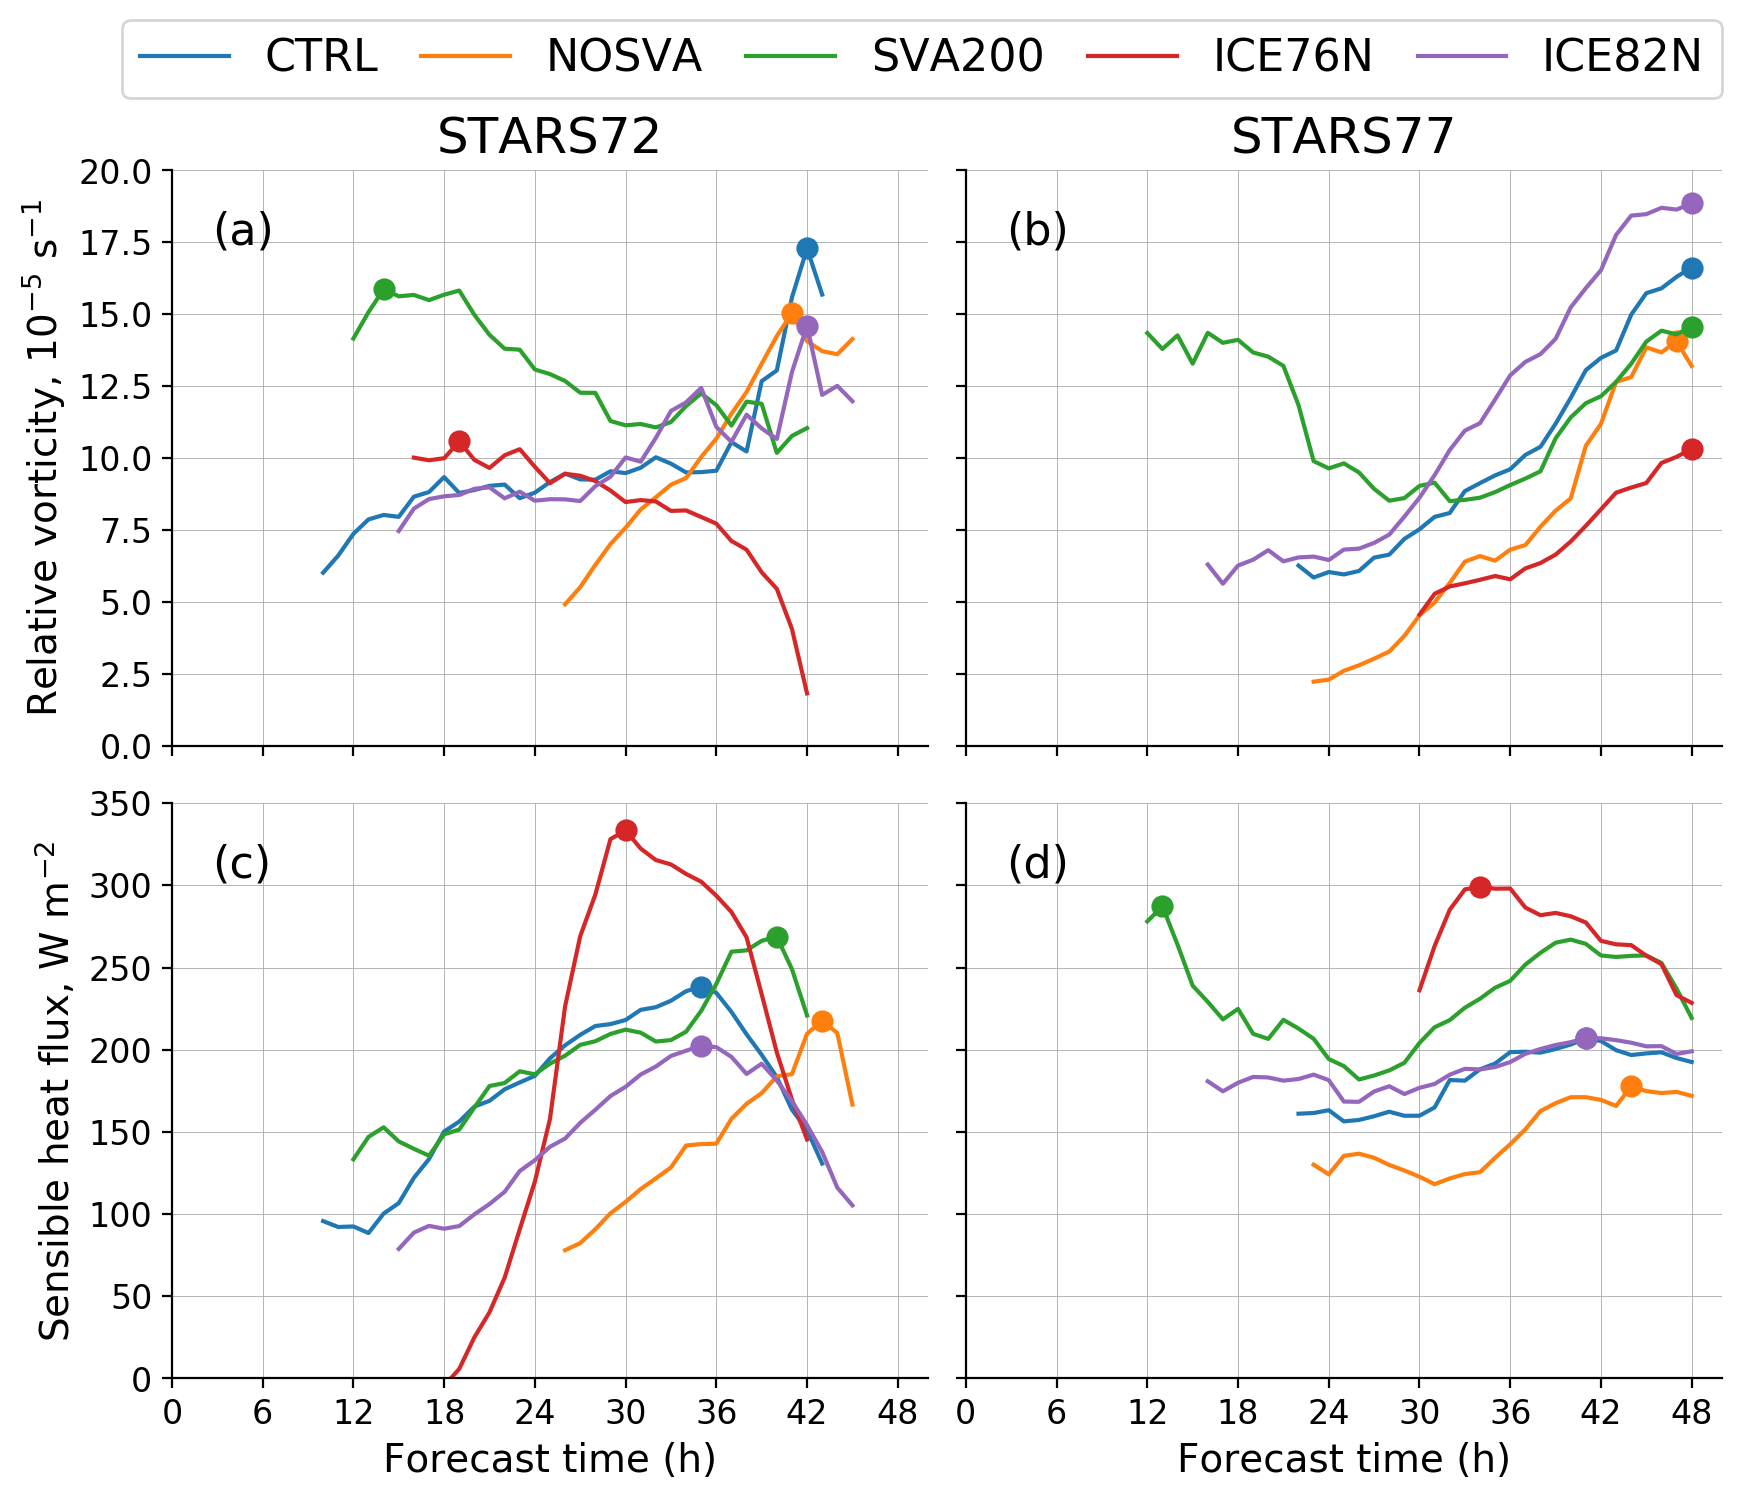

In [9]:
ncol = len(fcst_strs)
nrow = len(vrbls)
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(ncol*5, nrow*4),
                        sharey='row', sharex='col', squeeze=False)

axlabels = iter(string.ascii_lowercase)
for j, (axcol, fcst) in enumerate(zip(axs.T, fcst_strs)):
    for i, (ax, vrbl) in enumerate(zip(axcol, vrbls)):
        for run, color in zip(runs, cc):
            tr_df = tracks[fcst][run]
            fcst_hours = [int(i.total_seconds() / 3600)
                          for i in tr_df.time - datetime.strptime(fcst, '%Y%m%dT%H%MZ')]
            v = data[fcst][run][vrbl[0]]
            if vrbl[0] == 'slp':
                maxval_ind = (v*vrbl[1]['scl']).argmin()
            else:
                maxval_ind = (v*vrbl[1]['scl']).argmax()
            h1, = ax.plot(fcst_hours, v*vrbl[1]['scl'], label=run.upper(), **color, linewidth=1.5)
            ax.plot(fcst_hours[maxval_ind], v[maxval_ind]*vrbl[1]['scl'], marker='o', ms=7, **color)
            if j == 0:
                ax.set_ylabel(f"{vrbl[1]['ylabel']}, {misc.unit_format(abs(1/vrbl[1]['scl']), vrbl[1]['unit'])}")
            elif j == 1 and i == 0:
                ax.legend(bbox_to_anchor=(0.1, 0.925, 0.8, 0),
                          bbox_transform=fig.transFigure,
                          loc=3,
                          ncol=len(runs), mode="expand", borderaxespad=0.
                         )
                          #bbox_to_anchor=(1.2, 0.5))

        if i == 0:
            ax.set_title([*pl_cases.keys()][j])
        ax.set_xticks(range(0, 49, 6))
        ax.set_xlim(0, 50)
        ax.set_ylim(vrbl[1].get('ylim'))
        ax.grid(True, linewidth=0.33)
        for side in ['top', 'right']:
            ax.spines[side].set_visible(False)
            ax.tick_params(**{side: False})

for ax in axs[-1, :]:
    ax.set_xlabel('Forecast time (h)')

ax_labels = iter(string.ascii_lowercase)
for ax in axs.flat:
    txt = f'({next(ax_labels)})'
    at = AnchoredText(txt, prop=dict(size=16), frameon=False, loc=2)
    ax.add_artist(at)


fig.subplots_adjust(hspace=0.1, wspace=0.05)

In [10]:
fig.savefig(mypaths.plotdir / f'along_tracks_{"_".join([i[0] for i in vrbls])}')